In [1]:
import numpy as np

from requests import get
from requests.exceptions import RequestException
from contextlib import closing
from bs4 import BeautifulSoup

In [2]:
# read the web page
import requests

source = requests.get('https://en.wikipedia.org/wiki/Neighborhoods_in_New_York_City').text
soup = BeautifulSoup(source , 'lxml')

In [3]:
# read the table into dataframe
# after inspecting the webpage, the required table has attrs with class 'wikitable sortable'

import pandas as pd

table = soup.find('table', attrs={'class':'wikitable sortable'})
table_rows = table.find_all('tr')
l = []

for tr in table_rows:
    td = tr.find_all('td')
    row = [tr.text for tr in td]
    l.append(row)
    
overall_table = pd.DataFrame(l, columns=["A", "B","C","D","Neighborhoods"]);

In [4]:
neighborhood_table = overall_table[["Neighborhoods"]]
neighborhood_table.head()

#neighborhood_table = pd.DataFrame({"Neighborhoods": overall_table})
#neighborhood_table.head()

,Neighborhoods
0,None
1,"Melrose, Mott Haven, Port Morris\n"
2,"Hunts Point, Longwood\n"
3,"Claremont, Concourse Village, Crotona Park, Mo..."
4,"Concourse, Highbridge\n"


In [5]:
neighborhood_table.tail()
print(neighborhood_table.shape)

(61, 1)


In [6]:
neighborhood_table2 = neighborhood_table.loc[0:59 , :]
print(neighborhood_table2.tail())

# drop rows that contains all nulls
modified_neighborhood = neighborhood_table2.dropna(axis=0 , how='all');
print (modified_neighborhood.shape)

                                        Neighborhoods
55  Bellerose, Brookville, Cambria Heights, Floral...
56  Arverne, Bayswater, Belle Harbor, Breezy Point...
57  Arlington, Castleton Corners, Clifton, Concord...
58  Arrochar, Bloomfield, Bulls Head, Chelsea, Don...
59  Annadale, Arden Heights, Bay Terrace, Charlest...
(59, 1)


In [7]:
# remove '\n' characters from the dataframe

modified_neighborhood['Neighborhoods'] = modified_neighborhood['Neighborhoods'].str.replace('\n','');
print(modified_neighborhood.tail(15))

                                        Neighborhoods
45       East Elmhurst, Jackson Heights, North Corona
46                                   Corona, Elmhurst
47  Fresh Pond, Glendale, Maspeth, Middle Village,...
48                            Forest Hills, Rego Park
49  Bay Terrace, Beechhurst, College Point, Flushi...
50  Briarwood, Fresh Meadows, Holliswood, Jamaica ...
51  Kew Gardens, Ozone Park, Richmond Hill, Woodhaven
52  Howard Beach, Lindenwood, Richmond Hill, South...
53  Auburndale, Bayside, Douglaston, East Flushing...
54  Baisley Park, Jamaica, Hollis, Rochdale Villag...
55  Bellerose, Brookville, Cambria Heights, Floral...
56  Arverne, Bayswater, Belle Harbor, Breezy Point...
57  Arlington, Castleton Corners, Clifton, Concord...
58  Arrochar, Bloomfield, Bulls Head, Chelsea, Don...
59  Annadale, Arden Heights, Bay Terrace, Charlest...


E:\engineering_programs\Anaconda\anaconda_installation\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [8]:
# define a function to get coordinates
def get_latlng(neighborhood):
    # initialize your variable to None
    lat_lng_coords = None
    # loop until you get the coordinates
    while(lat_lng_coords is None):
        g = geocoder.arcgis('{}, New York, USA'.format(neighborhood))
        lat_lng_coords = g.latlng
    return lat_lng_coords

In [9]:
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
import geocoder # to get coordinates

# call the function to get the coordinates, store in a new list using list comprehension
# consisting it into 3 parts so that the prgram does not crash, as the neighborhood number is large
coords1 = [ get_latlng(neighborhood) for neighborhood in modified_neighborhood["Neighborhoods"][:20].tolist() ]

In [10]:
coords2 = [ get_latlng(neighborhood) for neighborhood in modified_neighborhood["Neighborhoods"][20:40].tolist() ]

In [11]:
coords3 = [ get_latlng(neighborhood) for neighborhood in modified_neighborhood["Neighborhoods"][40:50].tolist() ]

In [12]:
coords4 = [ get_latlng(neighborhood) for neighborhood in modified_neighborhood["Neighborhoods"][50:55].tolist() ]

In [13]:
#coords5 = [ get_latlng(neighborhood) for neighborhood in modified_neighborhood["Neighborhoods"][55:].tolist() ]

In [14]:
type(coords1)

list

In [15]:
final_lat_long_list = coords1 + coords2 + coords3 + coords4
print(np.shape(final_lat_long_list))
#print(final_lat_long_list)

(55, 2)


In [16]:
#Converting the lat_long list to dataframe
final_lat_long = pd.DataFrame(final_lat_long_list)
print(final_lat_long.shape)
headers = ("Latitude","Longitude")
final_lat_long.columns = headers
print(final_lat_long.head())

# Removing the last four rows from neighborhood as it is too long and hard to get its coords
removed_long_neighbors = modified_neighborhood.loc[0:55 , :]
print(removed_long_neighbors.shape)
#removed_long_neighbors.tail()

(55, 2)
    Latitude  Longitude
0  40.819900 -73.910380
1  40.812420 -73.884500
2  40.835135 -73.894649
3  40.842351 -73.930896
4  40.854730 -73.911320
(55, 1)


In [17]:
# Concatinating Latitude and Longitude columns to the neighborhoud dataframe

Latitude = final_lat_long.iloc[:,0];
Longitude = final_lat_long.iloc[:,1];


Latitude.reset_index(drop=True, inplace=True)
Longitude.reset_index(drop=True, inplace=True)
removed_long_neighbors.reset_index(drop=True, inplace=True)


final_neighborhood = pd.concat([removed_long_neighbors,Latitude,Longitude], axis=1);
final_neighborhood.head()

,Neighborhoods,Latitude,Longitude
0,"Melrose, Mott Haven, Port Morris",40.819900,-73.910380
1,"Hunts Point, Longwood",40.812420,-73.884500
2,"Claremont, Concourse Village, Crotona Park, Mo...",40.835135,-73.894649
3,"Concourse, Highbridge",40.842351,-73.930896
4,"Fordham, Morris Heights, Mount Hope, Universit...",40.854730,-73.911320


## drawing the map of New York

In [18]:
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

address = 'New York'

geolocator = Nominatim(user_agent="my-application")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of New York are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of New York are 40.7127281, -74.0060152.


In [19]:
# create map of New York using latitude and longitude values

import folium # map rendering library

New_York_map = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng , neighborhood in zip(final_neighborhood['Latitude'], final_neighborhood['Longitude'], final_neighborhood['Neighborhoods']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7).add_to(New_York_map)  
    
New_York_map

## Use the Foursquare API to explore the neighborhoods

In [20]:
# define Foursquare Credentials and Version
# credentials from https://foursquare.com/developers/apps/XSCQCOQYVFAKW0TD15RUBVT43VAF1IM3LJQUCH4OD3GVH02K/settings

CLIENT_ID = 'XXXXXXXXXX' # my Foursquare ID
CLIENT_SECRET = 'XXXXXXXXXX' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

#print('Your credentails:')
#print('CLIENT_ID: ' + CLIENT_ID)
#print('CLIENT_SECRET:' + CLIENT_SECRET)

In [21]:
# Now, let's get the top 100 venues (any place that contains an activity .. Starbucks for example) ..
# that are within a radius of 500 meters.

radius = 500
LIMIT = 100

venues = []

for lat, long, neighborhood in zip(final_neighborhood['Latitude'], final_neighborhood['Longitude'], final_neighborhood['Neighborhoods']):
    url = "https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}".format(
        CLIENT_ID,
        CLIENT_SECRET,
        VERSION,
        lat,
        long,
        radius, 
        LIMIT)
    
    results = requests.get(url).json()["response"]['groups'][0]["items"]
    
    for venue in results:
        venues.append((
            neighborhood,
            lat, 
            long, 
            venue['venue']['name'], 
            venue['venue']['location']['lat'], 
            venue['venue']['location']['lng'],  
            venue['venue']['categories'][0]['name']))

In [22]:
# convert the venues list into a new DataFrame
venues_df = pd.DataFrame(venues)

# define the column names
venues_df.columns = ['Neighborhood', 'Latitude', 'Longitude', 'VenueName', 'VenueLatitude', 'VenueLongitude', 'VenueCategory']

print(venues_df.shape)
venues_df.head()

(2006, 7)


,Neighborhood,Latitude,Longitude,VenueName,VenueLatitude,VenueLongitude,VenueCategory
0,"Melrose, Mott Haven, Port Morris",40.8199,-73.91038,Blink Fitness,40.819348,-73.910373,Gym / Fitness Center
1,"Melrose, Mott Haven, Port Morris",40.8199,-73.91038,Senshi Okami Martial Arts Center,40.819295,-73.914158,Martial Arts Dojo
2,"Melrose, Mott Haven, Port Morris",40.8199,-73.91038,Landin Mac & Cheese,40.820028,-73.915886,Mac & Cheese Joint
3,"Melrose, Mott Haven, Port Morris",40.8199,-73.91038,Perry Coffee Shop.,40.823181,-73.910928,Diner
4,"Melrose, Mott Haven, Port Morris",40.8199,-73.91038,Blink Fitness,40.819470,-73.910522,Gym


In [23]:
# Let's find out how many unique categories can be curated from all the returned venues

print('There are {} uniques categories.'.format(len(venues_df['VenueCategory'].unique())))
venues_df['VenueCategory'].unique()[:50]

There are 296 uniques categories.


array(['Gym / Fitness Center', 'Martial Arts Dojo', 'Mac & Cheese Joint',
       'Diner', 'Gym', 'Donut Shop', 'Italian Restaurant', 'Supermarket',
       'Clothing Store', 'Art Gallery', 'Mexican Restaurant',
       'Sandwich Place', 'Mobile Phone Shop', 'Pizza Place',
       'Discount Store', 'Supplement Shop', 'Pharmacy',
       'Paper / Office Supplies Store', 'Grocery Store',
       'Department Store', 'Spa', 'Bus Station', 'Intersection',
       'Juice Bar', 'Spanish Restaurant', 'BBQ Joint', 'Bank',
       'Farmers Market', 'Restaurant', 'Chinese Restaurant',
       'Waste Facility', 'Park', 'Laundromat', 'Bridge', 'Historic Site',
       'Food Truck', 'College Rec Center', 'Skate Park',
       'African Restaurant', 'Wings Joint', 'Latin American Restaurant',
       'Bakery', 'Shoe Store', 'Fast Food Restaurant', 'Deli / Bodega',
       'Burger Joint', 'Fried Chicken Joint', 'Metro Station',
       'Convenience Store', 'Athletics & Sports'], dtype=object)

In [24]:

new_york_value_counts = pd.DataFrame(venues_df['VenueCategory'].value_counts());
new_york_value_counts['VenueCategory1'] = new_york_value_counts.index
new_york_value_counts.columns = ["count" , "VenueCategory"]
print(new_york_value_counts.shape)
new_york_value_counts

(296, 2)


,count,VenueCategory
Pizza Place,80,Pizza Place
Bar,63,Bar
Coffee Shop,58,Coffee Shop
Deli / Bodega,53,Deli / Bodega
Bakery,52,Bakery
Mexican Restaurant,47,Mexican Restaurant
Chinese Restaurant,40,Chinese Restaurant
Café,40,Café
Italian Restaurant,39,Italian Restaurant
Sandwich Place,37,Sandwich Place


## Grouping venues types together

#### Restaurants :

In [25]:
# getting all rows that the venue type contain the word restaurant
print('number of values contains restaurant word =' , len(new_york_value_counts[new_york_value_counts['VenueCategory'].str.contains('Restaurant')]))
new_york_restaurants = new_york_value_counts[new_york_value_counts['VenueCategory'].str.contains('Restaurant')]["count"].sum()
print('count of all restaurant = ' , new_york_restaurants)

# remove all venues containing 'restaurant'
new_york_final_counts = new_york_value_counts.drop(
    new_york_value_counts[new_york_value_counts['VenueCategory'].str.contains('Restaurant')].index, inplace = False)
print(new_york_final_counts.shape)
new_york_final_counts

# adding restaurant row containing the final count of all restaurants
#new_york_final_counts.append({'count':new_york_restaurants , 'VenueCategory':'Restaurants'}, ignore_index=True)
new_york_final_counts.loc['Restaurants'] = (new_york_restaurants , 'Restaurants')

print(new_york_final_counts.shape)
#new_york_final_counts

number of values contains restaurant word = 58
count of all restaurant =  489
(238, 2)
(239, 2)


#### Other food places

In [26]:
print('number of other food places =' , len(new_york_final_counts[new_york_final_counts['VenueCategory'].str.contains
    ('Pizza|Sandwich|Chicken|Food|Burger|Diner|Deli|Steakhouse|Joint|Taco|Buffet|Breakfast|Snack|Soup|Gastropub|Burrito')]))
new_york_food_places = new_york_final_counts[new_york_final_counts['VenueCategory'].str.contains
    ('Pizza|Sandwich|Chicken|Food|Burger|Diner|Deli|Steakhouse|Joint|Taco|Buffet|Breakfast|Snack|Soup|Gastropub|Burrito')]["count"].sum()
print('count of other food places = ' , new_york_food_places)

# remove all venues containing these words
new_york_final_counts = new_york_final_counts.drop(
    new_york_final_counts[new_york_final_counts['VenueCategory'].str.contains
    ('Pizza|Sandwich|Chicken|Food|Burger|Diner|Deli|Steakhouse|Joint|Taco|Buffet|Breakfast|Snack|Soup|Gastropub|Burrito')
                         ].index, inplace = False)
print(new_york_final_counts.shape)

#update restaurants count
new_york_final_counts.loc[new_york_final_counts['VenueCategory'] == 'Restaurants', ['count']] = new_york_restaurants + new_york_food_places

print(new_york_final_counts.shape)
#new_york_final_counts

number of other food places = 23
count of other food places =  296
(216, 2)
(216, 2)


#### Bars :

In [27]:
print('number of Bars =' , len(new_york_final_counts[new_york_final_counts['VenueCategory']
                                                .str.contains('Bar|pub|Nightclub|Pub')]))
new_york_Bars = new_york_final_counts[new_york_final_counts['VenueCategory']
                                             .str.contains('Bar|pub|Nightclub|Pub')]["count"].sum()
print('count of Bars = ' , new_york_Bars)

# remove all venues containing 'restaurant'
new_york_final_counts = new_york_final_counts.drop(
    new_york_final_counts[new_york_final_counts['VenueCategory'].str.contains('Bar|pub|Nightclub|Pub')].index, inplace = False)
print(new_york_final_counts.shape)

# adding new row for Bars
new_york_final_counts.loc['Bars'] = (new_york_Bars , 'Bars')

print(new_york_final_counts.shape)
#new_york_final_counts

number of Bars = 18
count of Bars =  162
(198, 2)
(199, 2)


#### Shopping and shops :

In [28]:
print('number of shops =' , len(new_york_final_counts[new_york_final_counts['VenueCategory'].str.contains
    ('Shop|Shopping|Bakery|Store|Boutique|Pharmacy|Supermarket|Market|Salad|Butcher|Cleaner|Bookstore|Laundromat|Grocery|Auto|Car')]))
new_york_Shops = new_york_final_counts[new_york_final_counts['VenueCategory'].str.contains
    ('Shop|Shopping|Bakery|Store|Boutique|Pharmacy|Supermarket|Market|Salad|Butcher|Cleaner|Bookstore|Laundromat|Grocery|Auto|Car')]["count"].sum()
print('count of shops = ' , new_york_Shops)

# remove all venues containing these words
new_york_final_counts = new_york_final_counts.drop(
    new_york_final_counts[new_york_final_counts['VenueCategory'].str.contains
    ('Shop|Shopping|Bakery|Store|Boutique|Pharmacy|Supermarket|Market|Salad|Butcher|Cleaner|Bookstore|Laundromat|Grocery|Auto|Car')].index, inplace = False)
print(new_york_final_counts.shape)

# adding new row for Shops
new_york_final_counts.loc['Shops'] = (new_york_Shops , 'Shops')

print(new_york_final_counts.shape)
#new_york_final_counts

number of shops = 78
count of shops =  570
(121, 2)
(122, 2)


#### Fitness and sports :

In [29]:
print('number of fitness places =' , len(new_york_final_counts[new_york_final_counts['VenueCategory'].str.contains
                            ('Gym|Spa|Basketball|Yoga|Playground|Martial|Sports|Bike|Tennis')]))
new_york_fitness_places = new_york_final_counts[new_york_final_counts['VenueCategory'].str.contains
                            ('Gym|Spa|Basketball|Yoga|Playground|Martial|Sports|Bike|Tennis')]["count"].sum()
print('count of fitness places = ' , new_york_fitness_places)

# remove all venues containing these words
new_york_final_counts = new_york_final_counts.drop(
    new_york_final_counts[new_york_final_counts['VenueCategory'].str.contains
                          ('Gym|Spa|Basketball|Yoga|Playground|Martial|Sports|Bike|Tennis')].index, inplace = False)
print(new_york_final_counts.shape)

# adding new row for fitness places
new_york_final_counts.loc['Fitness & sports'] = (new_york_fitness_places , 'Fitness & sports')

print(new_york_final_counts.shape)
#new_york_final_counts

number of fitness places = 16
count of fitness places =  115
(106, 2)
(107, 2)


#### Entertainment

In [30]:
print('number of entertaining places =' , len(new_york_final_counts[new_york_final_counts['VenueCategory'].str.contains
    ('Circus|Club|Opera|Fountain|Arcade|Pier|Pool|Boat|Gallery|Boutique|Art|Arts|Theater|Hall|Plaza|Dance|Entertainment|Music|Bowling|Golf|Beach')]))
new_york_entertaining_places = new_york_final_counts[new_york_final_counts['VenueCategory'].str.contains
    ('Circus|Club|Opera|Fountain|Arcade|Pier|Pool|Boat|Gallery|Boutique|Art|Arts|Theater|Hall|Plaza|Dance|Entertainment|Music|Bowling|Golf|Beach')]["count"].sum()
print('count of entertaining places = ' , new_york_entertaining_places)

# remove all venues containing these words
new_york_final_counts = new_york_final_counts.drop(
    new_york_final_counts[new_york_final_counts['VenueCategory'].str.contains
    ('Circus|Club|Opera|Fountain|Arcade|Pier|Pool|Boat|Gallery|Boutique|Art|Arts|Theater|Hall|Plaza|Dance|Entertainment|Music|Bowling|Golf|Beach')].index, inplace = False)
print(new_york_final_counts.shape)

# adding new row for entertaining places
new_york_final_counts.loc['entertaining places'] = (new_york_entertaining_places , 'entertaining places')

print(new_york_final_counts.shape)
#new_york_final_counts

number of entertaining places = 31
count of entertaining places =  104
(76, 2)
(77, 2)


#### Hotels :

In [31]:
print('number of Hotels =' , len(new_york_final_counts[new_york_final_counts['VenueCategory'].str.contains
                                    ('Hotel|Motel|Hostel|Lounge')]))
new_york_Hotels = new_york_final_counts[new_york_final_counts['VenueCategory'].str.contains
                                    ('Hotel|Motel|Hostel|Lounge')]["count"].sum()
print('count of Hotels = ' , new_york_Hotels)

# remove all venues containing these words
new_york_final_counts = new_york_final_counts.drop(
    new_york_final_counts[new_york_final_counts['VenueCategory'].str.contains
                          ('Hotel|Motel|Hostel|Lounge')].index, inplace = False)
print(new_york_final_counts.shape)

# adding new row for Hotels
new_york_final_counts.loc['Hotels'] = (new_york_Hotels , 'Hotels')

print(new_york_final_counts.shape)
#new_york_final_counts

number of Hotels = 6
count of Hotels =  35
(71, 2)
(72, 2)


#### Coffee and Tea shops

In [32]:
print('number of Coffee shops =' , len(new_york_final_counts[new_york_final_counts['VenueCategory'].str.contains
                                    ('Coffee|Café|Tea|Bistro')]))
new_york_Cafe = new_york_final_counts[new_york_final_counts['VenueCategory'].str.contains
                                    ('Coffee|Café|Tea|Bistro')]["count"].sum()
print('count of Coffee shops = ' , new_york_Cafe)

# remove all venues containing these words
new_york_final_counts = new_york_final_counts.drop(
    new_york_final_counts[new_york_final_counts['VenueCategory'].str.contains
                          ('Coffee|Café|Tea|Bistro')].index, inplace = False)
print(new_york_final_counts.shape)

# adding new row for coffee and tea shops
new_york_final_counts.loc['Coffee shops'] = (new_york_Cafe , 'Coffee shops')

print(new_york_final_counts.shape)
#new_york_final_counts

number of Coffee shops = 4
count of Coffee shops =  44
(68, 2)
(69, 2)


#### Green places :

In [33]:
print('number of Green places =' , len(new_york_final_counts[new_york_final_counts['VenueCategory'].str.contains
                                    ('Park|Garden|Field|Farm')]))
new_york_Green_Places = new_york_final_counts[new_york_final_counts['VenueCategory'].str.contains
                                    ('Park|Garden|Field|Farm')]["count"].sum()
print('count of Green places = ' , new_york_Green_Places)

# remove all venues containing these words
new_york_final_counts = new_york_final_counts.drop(
    new_york_final_counts[new_york_final_counts['VenueCategory'].str.contains
                          ('Park|Garden|Field|Farm')].index, inplace = False)
print(new_york_final_counts.shape)

# adding new row for coffee and tea shops
new_york_final_counts.loc['Green places'] = (new_york_Green_Places , 'Green places')

print(new_york_final_counts.shape)
#new_york_final_counts

number of Green places = 7
count of Green places =  49
(62, 2)
(63, 2)


#### Transportation Spaces :

In [34]:
print('number of Transportion Spaces = ' , len(new_york_final_counts[new_york_final_counts['VenueCategory'].str.contains
                                    ('Bus|Station|Bridge|Heliport|Intersection|Airport|Trail')]))
new_york_Transportion_stations = new_york_final_counts[new_york_final_counts['VenueCategory'].str.contains
                                    ('Bus|Station|Bridge|Heliport|Intersection|Airport|Trail')]["count"].sum()
print('count of Transportion Spaces = ' , new_york_Transportion_stations)

# remove all venues containing these words
new_york_final_counts = new_york_final_counts.drop(
    new_york_final_counts[new_york_final_counts['VenueCategory'].str.contains
                          ('Bus|Station|Bridge|Heliport|Intersection|Airport|Trail')].index, inplace = False)
print(new_york_final_counts.shape)

# adding new row for coffee and tea shops
new_york_final_counts.loc['Transportion Spaces'] = (new_york_Transportion_stations , 'Transportion Spaces')

print(new_york_final_counts.shape)
#new_york_final_counts

number of Transportion Spaces =  13
count of Transportion Spaces =  31
(50, 2)
(51, 2)


#### tourism places

In [35]:
print('number of tourism places =' , len(new_york_final_counts[new_york_final_counts['VenueCategory'].str.contains
                                    ('Museum|Temple|Landmark|Scenic|Historic')]))
new_york_tourism_places = new_york_final_counts[new_york_final_counts['VenueCategory'].str.contains
                                    ('Museum|Temple|Landmark|Scenic|Historic')]["count"].sum()
print('count of tourism places = ' , new_york_tourism_places)

# remove all venues containing these words
new_york_final_counts = new_york_final_counts.drop(
    new_york_final_counts[new_york_final_counts['VenueCategory'].str.contains
                          ('Museum|Temple|Landmark|Scenic|Historic')].index, inplace = False)
print(new_york_final_counts.shape)

# adding new row for coffee and tea shops
new_york_final_counts.loc['tourism places'] = (new_york_tourism_places , 'tourism places')

print(new_york_final_counts.shape)
new_york_final_counts

number of tourism places = 6
count of tourism places =  18
(45, 2)
(46, 2)


,count,VenueCategory
Bank,30,Bank
Speakeasy,6,Speakeasy
Nail Salon,6,Nail Salon
Platform,5,Platform
Residential Building (Apartment / Condo),4,Residential Building (Apartment / Condo)
Health & Beauty Service,3,Health & Beauty Service
Cycle Studio,3,Cycle Studio
Animal Shelter,2,Animal Shelter
Moving Target,2,Moving Target
Library,2,Library


#### Remaining venues :

In [36]:
print('number of Other venues =' , len(new_york_final_counts[new_york_final_counts["count"] < 18]))
new_york_other_venues = new_york_final_counts[new_york_final_counts["count"] < 18]["count"].sum()
print('count of Other venues = ' , new_york_other_venues)

# remove all venues containing these words 
new_york_final_counts = new_york_final_counts.drop(
    new_york_final_counts[new_york_final_counts["count"] < 18].index, inplace = False)
print(new_york_final_counts.shape)

# adding new row for coffee and tea shops
new_york_final_counts.loc['Other venues'] = (new_york_other_venues , 'Other venues')

#print(new_york_final_counts.shape)
new_york_final_counts

number of Other venues = 35
count of Other venues =  63
(11, 2)


,count,VenueCategory
Bank,30,Bank
Restaurants,785,Restaurants
Bars,162,Bars
Shops,570,Shops
Fitness & sports,115,Fitness & sports
entertaining places,104,entertaining places
Hotels,35,Hotels
Coffee shops,44,Coffee shops
Green places,49,Green places
Transportion Spaces,31,Transportion Spaces


# Toronto venues dataframe

In [37]:
# Import toronto venues dataframe

toronto_venues_df = pd.read_csv('Toronto_venues_df.csv', index_col=0 , encoding='latin1')
print(toronto_venues_df.shape)
toronto_venues_df.head()

(1615, 9)


,PostalCode,Borough,Neighborhood,BoroughLatitude,BoroughLongitude,VenueName,VenueLatitude,VenueLongitude,VenueCategory
0,M4E,East Toronto,The Beaches,43.676357,-79.293031,Glen Manor Ravine,43.676821,-79.293942,Trail
1,M4E,East Toronto,The Beaches,43.676357,-79.293031,The Big Carrot Natural Food Market,43.678879,-79.297734,Health Food Store
2,M4E,East Toronto,The Beaches,43.676357,-79.293031,Grover Pub and Grub,43.679181,-79.297215,Pub
3,M4E,East Toronto,The Beaches,43.676357,-79.293031,Upper Beaches,43.680563,-79.292869,Neighborhood
4,M4K,East Toronto,"The Danforth West, Riverdale",43.679557,-79.352188,MenEssentials,43.677820,-79.351265,Cosmetics Shop


In [38]:
toronto_value_counts = pd.DataFrame(toronto_venues_df['VenueCategory'].value_counts());
print(toronto_value_counts.shape)
toronto_value_counts

(236, 1)


,VenueCategory
Coffee Shop,142
Café,89
Restaurant,56
Italian Restaurant,41
Hotel,35
Park,35
Japanese Restaurant,33
Bakery,32
Sushi Restaurant,26
Bar,26


In [39]:
toronto_value_counts['VenueCategory1'] = toronto_value_counts.index
toronto_value_counts.columns = ["count" , "VenueCategory"]
print(toronto_value_counts.shape)
toronto_value_counts

(236, 2)


,count,VenueCategory
Coffee Shop,142,Coffee Shop
Café,89,Café
Restaurant,56,Restaurant
Italian Restaurant,41,Italian Restaurant
Hotel,35,Hotel
Park,35,Park
Japanese Restaurant,33,Japanese Restaurant
Bakery,32,Bakery
Sushi Restaurant,26,Sushi Restaurant
Bar,26,Bar


## Grouping venues types together

#### Restaurants

In [40]:
# getting all rows that the venue type contain the word restaurant
print('number of values contains restaurant word =' , len(toronto_value_counts[toronto_value_counts['VenueCategory'].str.contains('Restaurant')]))
Toronto_restaurants = toronto_value_counts[toronto_value_counts['VenueCategory'].str.contains('Restaurant')]["count"].sum()
print('count of all restaurant = ' , Toronto_restaurants)

# remove all venues containing 'restaurant'
Toronto_final_counts = toronto_value_counts.drop(
    toronto_value_counts[toronto_value_counts['VenueCategory'].str.contains('Restaurant')].index, inplace = False)
print(Toronto_final_counts.shape)

# adding restaurant row containing the final count of all restaurants
Toronto_final_counts.loc['Restaurants'] = (Toronto_restaurants , 'Restaurants')

print(Toronto_final_counts.shape)
#new_york_final_counts

number of values contains restaurant word = 44
count of all restaurant =  385
(192, 2)
(193, 2)


#### Other food places :

In [41]:
print('number of other food places =' , len(Toronto_final_counts[Toronto_final_counts['VenueCategory'].str.contains
    ('Pizza|Sandwich|Chicken|Food|Burger|Diner|Deli|Steakhouse|Joint|Taco|Buffet|Breakfast|Snack|Soup|Gastropub|poke|Burrito|Creperie|Noodle')]))
Toronto_food_places = Toronto_final_counts[Toronto_final_counts['VenueCategory'].str.contains
    ('Pizza|Sandwich|Chicken|Food|Burger|Diner|Deli|Steakhouse|Joint|Taco|Buffet|Breakfast|Snack|Soup|Gastropub|poke|Burrito|Creperie|Noodle')]["count"].sum()
print('count of other food places = ' , Toronto_food_places)

# remove all venues containing these words
Toronto_final_counts = Toronto_final_counts.drop(
    Toronto_final_counts[Toronto_final_counts['VenueCategory'].str.contains
    ('Pizza|Sandwich|Chicken|Food|Burger|Diner|Deli|Steakhouse|Joint|Taco|Buffet|Breakfast|Snack|Soup|Gastropub|poke|Burrito|Creperie|Noodle')
                         ].index, inplace = False)
print(Toronto_final_counts.shape)

#update restaurants count
Toronto_final_counts.loc[Toronto_final_counts['VenueCategory'] == 'Restaurants', ['count']] = Toronto_restaurants + Toronto_food_places

print(Toronto_final_counts.shape)
#new_york_final_counts

number of other food places = 24
count of other food places =  187
(169, 2)
(169, 2)


#### Bars :

In [42]:
print('number of Bars =' , len(Toronto_final_counts[Toronto_final_counts['VenueCategory']
                                                .str.contains('Bar|pub|Nightclub|Pub')]))
Toronto_Bars = Toronto_final_counts[Toronto_final_counts['VenueCategory']
                                             .str.contains('Bar|pub|Nightclub|Pub')]["count"].sum()
print('count of Bars = ' , Toronto_Bars)

# remove all venues containing 'restaurant'
Toronto_final_counts = Toronto_final_counts.drop(
    Toronto_final_counts[Toronto_final_counts['VenueCategory'].str.contains('Bar|pub|Nightclub|Pub')].index, inplace = False)
print(Toronto_final_counts.shape)

# adding new row for Bars
Toronto_final_counts.loc['Bars'] = (Toronto_Bars , 'Bars')

print(Toronto_final_counts.shape)
#new_york_final_counts

number of Bars = 14
count of Bars =  117
(155, 2)
(156, 2)


#### Shopping and shops :

In [43]:
print('number of shops =' , len(Toronto_final_counts[Toronto_final_counts['VenueCategory'].str.contains
    ('Shop|Shopping|Bakery|Store|Boutique|Pharmacy|Supermarket|Market|Salad|Butcher|Cleaner|Bookstore|Laundromat|Grocery|Auto|Car')]))
Toronto_Shops = Toronto_final_counts[Toronto_final_counts['VenueCategory'].str.contains
    ('Shop|Shopping|Bakery|Store|Boutique|Pharmacy|Supermarket|Market|Salad|Butcher|Cleaner|Bookstore|Laundromat|Grocery|Auto|Car')]["count"].sum()
print('count of shops = ' , Toronto_Shops)

# remove all venues containing these words
Toronto_final_counts = Toronto_final_counts.drop(
    Toronto_final_counts[Toronto_final_counts['VenueCategory'].str.contains
    ('Shop|Shopping|Bakery|Store|Boutique|Pharmacy|Supermarket|Market|Salad|Butcher|Cleaner|Bookstore|Laundromat|Grocery|Auto|Car')].index, inplace = False)
print(Toronto_final_counts.shape)

# adding new row for Shops
Toronto_final_counts.loc['Shops'] = (Toronto_Shops , 'Shops')

print(Toronto_final_counts.shape)
#new_york_final_counts

number of shops = 65
count of shops =  466
(91, 2)
(92, 2)


#### Fitness and sports :

In [44]:
print('number of fitness places =' , len(Toronto_final_counts[Toronto_final_counts['VenueCategory'].str.contains
                            ('Gym|Spa|Basketball|Yoga|Playground|Martial|Sports|Bike|Tennis|Stadium')]))
Toronto_fitness_places = Toronto_final_counts[Toronto_final_counts['VenueCategory'].str.contains
                            ('Gym|Spa|Basketball|Yoga|Playground|Martial|Sports|Bike|Tennis|Stadium')]["count"].sum()
print('count of fitness places = ' , Toronto_fitness_places)

# remove all venues containing these words
Toronto_final_counts = Toronto_final_counts.drop(
    Toronto_final_counts[Toronto_final_counts['VenueCategory'].str.contains
                          ('Gym|Spa|Basketball|Yoga|Playground|Martial|Sports|Bike|Tennis|Stadium')].index, inplace = False)
print(Toronto_final_counts.shape)

# adding new row for fitness places
Toronto_final_counts.loc['Fitness & sports'] = (Toronto_fitness_places , 'Fitness & sports')

print(Toronto_final_counts.shape)
#new_york_final_counts

number of fitness places = 14
count of fitness places =  70
(78, 2)
(79, 2)


#### Entertainment :

In [45]:
print('number of entertaining places =' , len(Toronto_final_counts[Toronto_final_counts['VenueCategory'].str.contains
    ('Circus|Club|Opera|Fountain|Arcade|Pier|Pool|Boat|Gallery|Boutique|Art|Arts|Theater|Hall|Plaza|Dance|Entertainment|Music|Bowling|Golf|Beach|Skating')]))
Toronto_entertaining_places = Toronto_final_counts[Toronto_final_counts['VenueCategory'].str.contains
    ('Circus|Club|Opera|Fountain|Arcade|Pier|Pool|Boat|Gallery|Boutique|Art|Arts|Theater|Hall|Plaza|Dance|Entertainment|Music|Bowling|Golf|Beach|Skating')]["count"].sum()
print('count of entertaining places = ' , Toronto_entertaining_places)

# remove all venues containing these words
Toronto_final_counts = Toronto_final_counts.drop(
    Toronto_final_counts[Toronto_final_counts['VenueCategory'].str.contains
    ('Circus|Club|Opera|Fountain|Arcade|Pier|Pool|Boat|Gallery|Boutique|Art|Arts|Theater|Hall|Plaza|Dance|Entertainment|Music|Bowling|Golf|Beach|Skating')].index, inplace = False)
print(Toronto_final_counts.shape)

# adding new row for entertaining places
Toronto_final_counts.loc['entertaining places'] = (Toronto_entertaining_places , 'entertaining places')

print(Toronto_final_counts.shape)
#new_york_final_counts

number of entertaining places = 19
count of entertaining places =  81
(60, 2)
(61, 2)


#### Hotels :

In [46]:
print('number of Hotels =' , len(Toronto_final_counts[Toronto_final_counts['VenueCategory'].str.contains
                                    ('Hotel|Motel|Hostel|Lounge')]))
Toronto_Hotels = Toronto_final_counts[Toronto_final_counts['VenueCategory'].str.contains
                                    ('Hotel|Motel|Hostel|Lounge')]["count"].sum()
print('count of Hotels = ' , Toronto_Hotels)

# remove all venues containing these words
Toronto_final_counts = Toronto_final_counts.drop(
    Toronto_final_counts[Toronto_final_counts['VenueCategory'].str.contains
                          ('Hotel|Motel|Hostel|Lounge')].index, inplace = False)
print(Toronto_final_counts.shape)

# adding new row for Hotels
Toronto_final_counts.loc['Hotels'] = (Toronto_Hotels , 'Hotels')

print(Toronto_final_counts.shape)
#new_york_final_counts

number of Hotels = 4
count of Hotels =  47
(57, 2)
(58, 2)


#### Coffee and Tea shops

In [47]:
print('number of Coffee shops =' , len(Toronto_final_counts[Toronto_final_counts['VenueCategory'].str.contains
                                    ('Coffee|Café|Tea|Bistro|Cafe|Cafeteria')]))
Toronto_Cafe = Toronto_final_counts[Toronto_final_counts['VenueCategory'].str.contains
                                    ('Coffee|Café|Tea|Bistro|Cafe|Cafeteria')]["count"].sum()
print('count of Coffee shops = ' , Toronto_Cafe)

# remove all venues containing these words
Toronto_final_counts = Toronto_final_counts.drop(
    Toronto_final_counts[Toronto_final_counts['VenueCategory'].str.contains
                          ('Coffee|Café|Tea|Bistro|Cafe|Cafeteria')].index, inplace = False)
print(Toronto_final_counts.shape)

# adding new row for coffee and tea shops
Toronto_final_counts.loc['Coffee shops'] = (Toronto_Cafe , 'Coffee shops')

print(Toronto_final_counts.shape)
#new_york_final_counts

number of Coffee shops = 5
count of Coffee shops =  108
(53, 2)
(54, 2)


#### Green spaces :

In [48]:
print('number of Green places =' , len(Toronto_final_counts[Toronto_final_counts['VenueCategory'].str.contains
                                    ('Park|Garden|Field|Farm')]))
Toronto_Green_Places = Toronto_final_counts[Toronto_final_counts['VenueCategory'].str.contains
                                    ('Park|Garden|Field|Farm')]["count"].sum()
print('count of Green places = ' , Toronto_Green_Places)

# remove all venues containing these words
Toronto_final_counts = Toronto_final_counts.drop(
    Toronto_final_counts[Toronto_final_counts['VenueCategory'].str.contains
                          ('Park|Garden|Field|Farm')].index, inplace = False)
print(Toronto_final_counts.shape)

# adding new row for coffee and tea shops
Toronto_final_counts.loc['Green places'] = (Toronto_Green_Places , 'Green places')

print(Toronto_final_counts.shape)
#new_york_final_counts

number of Green places = 5
count of Green places =  41
(49, 2)
(50, 2)


#### Transportation Spaces :

In [49]:
print('number of Transportion Spaces = ' , len(Toronto_final_counts[Toronto_final_counts['VenueCategory'].str.contains
                                    ('Bus|Station|Bridge|Heliport|Intersection|Airport|Trail')]))
Toronto_Transportion_stations = Toronto_final_counts[Toronto_final_counts['VenueCategory'].str.contains
                                    ('Bus|Station|Bridge|Heliport|Intersection|Airport|Trail')]["count"].sum()
print('count of Transportion Spaces = ' , Toronto_Transportion_stations)

# remove all venues containing these words
Toronto_final_counts = Toronto_final_counts.drop(
    Toronto_final_counts[Toronto_final_counts['VenueCategory'].str.contains
                          ('Bus|Station|Bridge|Heliport|Intersection|Airport|Trail')].index, inplace = False)
print(Toronto_final_counts.shape)

# adding new row for coffee and tea shops
Toronto_final_counts.loc['Transportion Spaces'] = (Toronto_Transportion_stations , 'Transportion Spaces')

print(Toronto_final_counts.shape)
#new_york_final_counts

number of Transportion Spaces =  9
count of Transportion Spaces =  20
(41, 2)
(42, 2)


#### Tourism places

In [50]:
print('number of tourism places =' , len(Toronto_final_counts[Toronto_final_counts['VenueCategory'].str.contains
                                    ('Museum|Temple|Landmark|Scenic|Historic')]))
Toronto_tourism_places = Toronto_final_counts[Toronto_final_counts['VenueCategory'].str.contains
                                    ('Museum|Temple|Landmark|Scenic|Historic')]["count"].sum()
print('count of tourism places = ' , Toronto_tourism_places)

# remove all venues containing these words
Toronto_final_counts = Toronto_final_counts.drop(
    Toronto_final_counts[Toronto_final_counts['VenueCategory'].str.contains
                          ('Museum|Temple|Landmark|Scenic|Historic')].index, inplace = False)
print(Toronto_final_counts.shape)

# adding new row for coffee and tea shops
Toronto_final_counts.loc['tourism places'] = (Toronto_tourism_places , 'tourism places')

print(Toronto_final_counts.shape)
Toronto_final_counts

number of tourism places = 5
count of tourism places =  14
(37, 2)
(38, 2)


,count,VenueCategory
Brewery,11,Brewery
Bank,11,Bank
Aquarium,5,Aquarium
Poke Place,5,Poke Place
Distribution Center,4,Distribution Center
Speakeasy,4,Speakeasy
General Travel,4,General Travel
Neighborhood,4,Neighborhood
IT Services,3,IT Services
Dog Run,3,Dog Run


#### Remaining Venues :

In [51]:
print('number of Other venues =' , len(Toronto_final_counts[Toronto_final_counts["count"] < 11]))
Toronto_other_venues = Toronto_final_counts[Toronto_final_counts["count"] < 11]["count"].sum()
print('count of Other venues = ' , Toronto_other_venues)

# remove all venues containing these words 
Toronto_final_counts = Toronto_final_counts.drop(
    Toronto_final_counts[Toronto_final_counts["count"] < 11].index, inplace = False)

Toronto_final_counts = Toronto_final_counts.drop(
    Toronto_final_counts[Toronto_final_counts["VenueCategory"] == 'Brewery'].index, inplace = False)

print(Toronto_final_counts.shape)

# adding new row for coffee and tea shops
Toronto_final_counts.loc['Other venues'] = (Toronto_other_venues+11 , 'Other venues')

#print(new_york_final_counts.shape)
#Toronto_final_counts

number of Other venues = 26
count of Other venues =  57
(11, 2)


In [52]:
Toronto_final_counts

,count,VenueCategory
Bank,11,Bank
Restaurants,572,Restaurants
Bars,117,Bars
Shops,466,Shops
Fitness & sports,70,Fitness & sports
entertaining places,81,entertaining places
Hotels,47,Hotels
Coffee shops,108,Coffee shops
Green places,41,Green places
Transportion Spaces,20,Transportion Spaces


In [53]:
new_york_final_counts

,count,VenueCategory
Bank,30,Bank
Restaurants,785,Restaurants
Bars,162,Bars
Shops,570,Shops
Fitness & sports,115,Fitness & sports
entertaining places,104,entertaining places
Hotels,35,Hotels
Coffee shops,44,Coffee shops
Green places,49,Green places
Transportion Spaces,31,Transportion Spaces


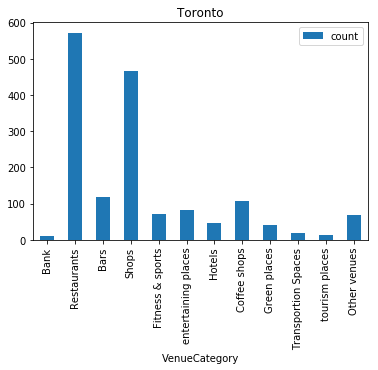

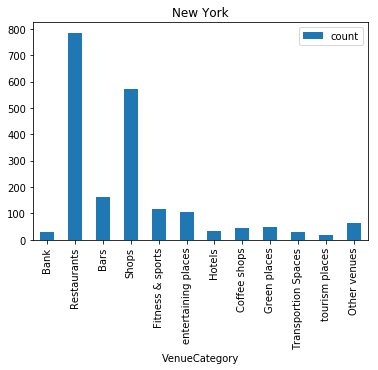

In [54]:
import matplotlib.pyplot as plt

ax = Toronto_final_counts.plot.bar(x='VenueCategory', y='count' , title='Toronto')
ax2 = new_york_final_counts.plot.bar(x='VenueCategory', y='count' , title='New York')

#new_york_final_counts.plot(ax=ax)

plt.show()

I tried clusering the neighborhoods according to the similarities between the venues each neighborhood contains using K-Means clusterning technique, but more than 90% of the neighborhoods was assigned to one cluster in a random way and no observations could be driven from these clusters.

So, I decided to group all the semilier veneus together for each city and compare between New York and Toronto according to these final numbers which generally describe the type or the characteristic of the city.

## Observations :

At first, lets consider the area of each city to help us compare between the characteristic of each city in a better way : 

    - New York total area = 783.8 km²
    - Toronto total area = 630.2 km²

New york is bigger than Toronto with about 150 Km^2. So, it is ordinary that New York would have more specific venues and the two cities would share the same characteristic according to that venues.

#### Coffee shops and entertaining places :

First clear observation for me is the number of coffee and tea shops in the two cities, It is mentioned that New York is bigger than Toronto and that would affect the number of all types of venues. But despite of that, Toronto has much more coffee shops than New York.

It can be observed that people in Toronto spend much time just sitting in coffee shops drinking some hot drinks and this leads to large number of that kind of shops.

And although the number of entertaining places would be near for both cites, it seams that people in New York use these places more often than people in Toronto who prefer coffee shops in their ordinary days.

#### Green places and transportation stations :

Number of green areas are so close in both cities, which means that Toronoto is more greener city than New York. This also reflects on the number of transportation places (Bus stations, Metro Stations and Gas stations) which is greater in New York.

##### Where to spend vacation? ( entertaining places - tourist attractions - Hotels) :

New York has much more entertaining and also tourism places, which makes it a better decision to spend your vacation in. But it would also be easier to stay in Toronto than New York because of its large number of hotels that would make it easier to find an available one.

#### Sports and Fitness :

New York has more sports and fitness places and also more different kinds of these places (if we display all kinds of venues categorized in sports and fitness places). These places including Gyms, Yoga studios, Spas, Boxing, Basketball, Tennis and Marial arts.

This variety make it easier for people live in New York to practice whatever the sport each one loves.

#### Other observations :

New York is more financial city than Toronoto according to the number of Banks.
Also we can see that Toronoto is famous for Brewery (11 Brewery in it and none in New York)

_______________

#### Finally, above are some observations that we can make so easily just by comparing few numbers between two cities. By knowing the nature of one city, it could be used as a reference that we can use to conclude the nature of any city just by comparing its veneues numbers with our reference.
#### In addition, by taking the type and the quality of each venue we can get more accurate observations and more correct understanding of any city. 

=================================================================================================